### Random Forest를 partial linear 모형으로 세워서 vix를 예측해보기
- $y_{t} = y_{t-1} + y_{t-1}^{weekly} + y_{t-1}^{monthly} + f(X_{t-1})$
    - $y_{t-1}^{weekly} = \frac{1}{5}\sum^{5}_{j=1}y_{t-j}$
    - $y_{t-1}^{monthly} = \frac{1}{22}\sum^{22}_{j=1}y_{t-j}$
- random forest의 경우 default value로 진행하기
- 동일하게 rolling으로 진행
- random seed를 하나로 고정하고 진행 → 나의 경우 42

In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager, rcParams
font_name = font_manager.FontProperties(fname = "c:/windows/fonts/malgun.ttf").get_name()
rc('font', family = font_name)
rcParams["axes.unicode_minus"] = False

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.ensemble import RandomForestRegressor

#### Import data


In [84]:
# Line 7~16
df = pd.read_excel("../data/dataset_HARX(14).xlsx")
df.dropna(inplace = True) 
date = df["Code"].to_numpy() # The date
df.set_index(["Code"], inplace = True)
df = df.iloc[:5739, :] # to 1990-04-06 ~ 2013-01-15
                    # Fernandes et al.(2014) : 1990-04-05 ~ 2013-01-15
                    # But some values are NaN at 1990-04-05
                    # So I dropped 1990-04-05
data = df.to_numpy() # To matrix
# data = data[66:, :] # obsolete line if dropna performed correctly

In [85]:
df.head(2)

,lnVIX,HAR_5day,HAR_10day,HAR_22day,HAR_66day,SP_1day,SP_5day,SP_10day,SP_22day,SP_66day,...,SP_66day.1,S&PCOMP(MV).1,Oil_1day.1,Oil_5day.1,Oil_10day.1,Oil_22day.1,Oil_66day.1,T10Y3M.1,Credit Spread.1,USG6WIC(TW).1
Code,,,,,,,,,,,,,,,,,,,,,
1990-04-06,3.080073,3.074592,3.027489,3.004229,3.097588,-0.001909,0.000412,0.008445,0.009246,-0.053473,...,-0.054152,-0.001156,-0.017853,-0.030413,-0.028914,-0.091889,-0.163882,0.55,0.84,-0.000785
1990-04-09,3.104587,3.069806,3.040446,3.009772,3.099840,0.003786,0.007852,0.011016,0.003228,-0.041036,...,-0.053473,-0.001902,-0.014516,-0.057332,-0.062742,-0.088881,-0.212328,0.54,0.84,-0.001649


In [86]:
df.tail(2)

,lnVIX,HAR_5day,HAR_10day,HAR_22day,HAR_66day,SP_1day,SP_5day,SP_10day,SP_22day,SP_66day,...,SP_66day.1,S&PCOMP(MV).1,Oil_1day.1,Oil_5day.1,Oil_10day.1,Oil_22day.1,Oil_66day.1,T10Y3M.1,Credit Spread.1,USG6WIC(TW).1
Code,,,,,,,,,,,,,,,,,,,,,
2013-01-14,2.604170,2.607063,2.654235,2.774609,2.796113,-0.000931,0.005995,0.047518,0.029562,0.006652,...,0.007261,-0.000046,-0.002775,0.005036,0.029173,0.089385,0.019972,1.82,0.92,-0.002825
2013-01-15,2.606387,2.606033,2.625725,2.767197,2.794462,0.001128,0.010370,0.031846,0.030242,0.011242,...,0.006652,-0.000935,0.006180,0.010143,0.036124,0.092881,0.046308,1.81,0.93,-0.000503


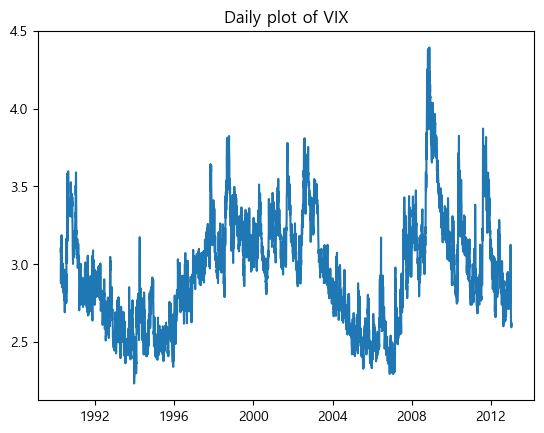

In [87]:
# plot vix
plt.plot(df["lnVIX"])
plt.title("Daily plot of VIX")
plt.show()

#### set the params for forecasting

In [88]:
npred = 3240
random_state = 42

linear_variables = ["HAR_5day", "HAR_10day", "HAR_22day"]
nonlinear_variables = list(df.columns[6:])
target_variable = "lnVIX"

lag = 5

#### Perform the forecasting

In [89]:
for i in range(npred, 0, -1)[:1]:
    
    date_window = date[(npred - i):(data.shape[0] - i)]

#     # To be function latter
#     result = run_pl_rf(date_window, lag, df, linear_variable, nonlinear_variables, target_variable)


In [111]:
"""define the func `run_pl_rf`"""

data = df.loc[date_window]

# set the X and Y
Y = data.loc[:, target_variable]
X = data.loc[:, linear_variables + nonlinear_variables]

# set the target X and y
X_window = date_window[:-lag]
y_window = date_window[-1:]

X = X.loc[X_window]
y = Y.loc[y_window]

# split the X to linear and nonlinear
X_linear = X.loc[:, linear_variables]
X_nonlinear = X.loc[:, nonlinear_variables]

# apply Robinson's estimator
